In [724]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error



import ast
import seaborn as sns
from plotnine import *

In [728]:
# Import the prewritten helper functions
# We are only using the color palette in this notebook
from py_helper_functions import *

In [688]:
listings = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Analysis-3/main/assignment-2/data/listings.csv')

In [689]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23185 entries, 0 to 23184
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23185 non-null  int64  
 1   listing_url                                   23185 non-null  object 
 2   scrape_id                                     23185 non-null  int64  
 3   last_scraped                                  23185 non-null  object 
 4   source                                        23185 non-null  object 
 5   name                                          23185 non-null  object 
 6   description                                   22822 non-null  object 
 7   neighborhood_overview                         13256 non-null  object 
 8   picture_url                                   23185 non-null  object 
 9   host_id                                       23185 non-null 

In [690]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [691]:
# drop some unnecessary columns
# these are mainly NAs,empty lists, urls, ids, or simpy variables that are just non relevant for the analysis
drop = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url',
                                  'host_name','host_since','host_location','host_about','host_thumbnail_url','host_picture_url','calendar_updated','calendar_last_scraped',
                                  'first_review','last_review','neighbourhood_group_cleansed','bathrooms','license','host_verifications','host_neighbourhood','has_availability',
                                  'minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                                  'minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_30','availability_60','availability_90','availability_365',]

listings = listings.drop(columns=drop)

In [692]:
# filter for local governments: melbourne, Port Philip, Stonnington, Yarra
# these neighborhoods are the central ones, where we would also have our apartments to price
listings = listings[listings['neighbourhood_cleansed'].isin(['Melbourne','Port Phillip','Stonnington','Yarra'])]

In [693]:
# filter based on property type, also rename them to a more general category
# define set of good property types, that fit the business needs
propertytypes = ["Entire rental unit",
                 "Private room in rental unit",
                 "Entire home",
                 "Entire condo",
                 "Private room in home",
                 "Apartment",
                 "House",
                 "Townhouse",
                 "Shared room in rental unit"]

# keep if property type is in the set
listings = listings.loc[lambda x: x["property_type"].isin(propertytypes)]

# rename to Rental unit or House
listings['property_type'] = listings['property_type'].apply(lambda x: 'Rental Unit' if "rental unit" in x else 'House')

In [694]:
listings["property_type"].value_counts()

Rental Unit    9612
House          2197
Name: property_type, dtype: int64

In [695]:
listings.shape

(11809, 37)

## CLEANING THE DATA

#### Cleaning numeric columns

In [696]:
# format binary variables
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]:
    listings[binary] = listings[binary].map({"t": 1, "f": 0})

# formatting columns with percentages
for perc in ["host_response_rate", "host_acceptance_rate"]:
    listings[perc] = listings[perc].replace("%", "", regex=True)
    listings[perc] = pd.to_numeric(listings[perc], errors="coerce")


# formatting price column
listings['price'] = pd.to_numeric(listings['price'].replace('[\$,]', '', regex=True), errors='coerce')
# drop where price is missing
listings = listings.dropna(subset=['price'])

#### Cleaning categorical/string columns

In [697]:
# Rename room type because it is too long
listings["room_type"] = listings["room_type"].map(
    {"Entire home/apt": "Entire",
        "Private room": "Private",
        "Shared room": "Shared",})

In [698]:
listings["room_type"].value_counts()

Entire     9801
Private    1910
Shared       98
Name: room_type, dtype: int64

In [699]:
# convert bathrooms_text to float
# def function to clean the bathroom text, split and space and set to int, if not possible set to 1
def clean_bathroom(text):
    try:
        return float(text.split(" ")[0])
    except:
        return text == 1 # the only missing was shared bath and Half-bath, which we can set to be 1

# apply function to the column
listings["bathrooms"] = listings["bathrooms_text"].apply(clean_bathroom)
listings.drop(columns="bathrooms_text", inplace=True)

In [700]:
listings["bathrooms"].value_counts()

1.0    8370
2.0    2489
1.5     449
2.5     224
3.0     110
3.5      61
0.0      24
8.0      20
4.0      15
7.5      13
5.5      12
5.0       9
8.5       5
4.5       4
6.0       2
7.0       2
Name: bathrooms, dtype: int64

In [701]:
# clean amenities column
# convert the amenities column to a list of amenities instead of a string
listings['new_amenities'] = listings['amenities'].apply(lambda x:ast.literal_eval(x)) # ast.literal_eval() to converts string to list so that way i can just get the values as a list

# create a list of all amenities
all_amentities = []

for list in listings['new_amenities']:
    for amenity in list:
        all_amentities.append(amenity)

# create a series of the 100 most frequent amenities
top100_amenities = pd.Series(all_amentities).value_counts().head(100)

# create a list of the top 100 amenities
amenities_list = top100_amenities.index.tolist()

# create a variable for each top 100 amenity
for my_amenities in amenities_list:
    listings[my_amenities] = listings['new_amenities'].apply(lambda x: 1 if my_amenities in x else 0)

# rename columns, as amenities can have spaces and uppercase characters
listings.columns = [name.replace(' ', '_').lower() for name in listings.columns]

# drop the original amenities column
listings = listings.drop(columns=['amenities', 'new_amenities'])

In [702]:
listings['host_response_time'].value_counts()

within an hour        5905
within a few hours    1041
within a day           490
a few days or more     158
Name: host_response_time, dtype: int64

In [703]:
listings.T

,1,5,6,7,9,11,13,14,16,18,...,23172,23173,23174,23176,23177,23178,23179,23180,23181,23182
id,12936,1181117,1188388,603007,1192689,1201338,1233439,621155,628370,633258,...,971364279376710218,971385848818575605,969280954896268255,971570547679229207,969308498306934752,971588505523400983,971599030604344292,971604763527045723,969314524632337156,971613881418926837
host_response_time,NaN,within a day,within an hour,NaN,within an hour,within an hour,within an hour,NaN,within an hour,NaN,...,within an hour,within an hour,within an hour,NaN,within an hour,NaN,within an hour,within an hour,within an hour,NaN
host_response_rate,NaN,100.0,100.0,NaN,100.0,100.0,97.0,NaN,100.0,NaN,...,93.0,100.0,100.0,NaN,100.0,NaN,100.0,100.0,100.0,NaN
host_acceptance_rate,NaN,0.0,100.0,NaN,85.0,100.0,98.0,NaN,100.0,NaN,...,99.0,96.0,100.0,NaN,100.0,NaN,99.0,91.0,100.0,NaN
host_is_superhost,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
board_games,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
shared_sauna,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,0,0
children’s_books_and_toys,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
bay_view,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [704]:
listings.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood',
       ...
       'breakfast', 'backyard', 'stainless_steel_oven', 'hot_tub',
       'barbecue_utensils', 'board_games', 'shared_sauna',
       'children’s_books_and_toys', 'bay_view', 'indoor_fireplace'],
      dtype='object', length=136)

In [705]:
for column in listings.columns:
    print(listings[column].value_counts())
    print(##################################################################
    )

12936                 1
730012775756724453    1
733178136488479333    1
733394343270677088    1
733456791437242260    1
                     ..
31009947              1
31011302              1
31019852              1
31025751              1
971613881418926837    1
Name: id, Length: 11809, dtype: int64

within an hour        5905
within a few hours    1041
within a day           490
a few days or more     158
Name: host_response_time, dtype: int64

100.0    5846
98.0      279
99.0      210
95.0      120
90.0      111
88.0      108
97.0      101
89.0       99
0.0        98
84.0       89
93.0       79
96.0       52
50.0       48
92.0       44
60.0       40
80.0       37
67.0       27
75.0       22
83.0       20
70.0       18
91.0       17
86.0       15
40.0       14
33.0       14
63.0       11
94.0       10
20.0        9
87.0        8
10.0        6
71.0        6
82.0        5
79.0        4
43.0        3
14.0        3
78.0        3
25.0        2
57.0        2
30.0        2
27.0        2
29.

## EDA

In [706]:
listings['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    11809.000000
mean       227.275044
std       1276.583704
min         14.000000
25%        107.000000
50%        150.000000
75%        213.000000
90%        350.000000
95%        500.000000
99%       1217.880000
max      99999.000000
Name: price, dtype: float64

In [713]:
## drop unreasonable prices
before = listings.shape[0]
listings = listings[listings['price'] <= 600]
after = listings.shape[0]
print(f"Dropped {before - after} rows with price <= 600")

Dropped 0 rows with price <= 600


Text(0, 0.5, 'Number of listings')

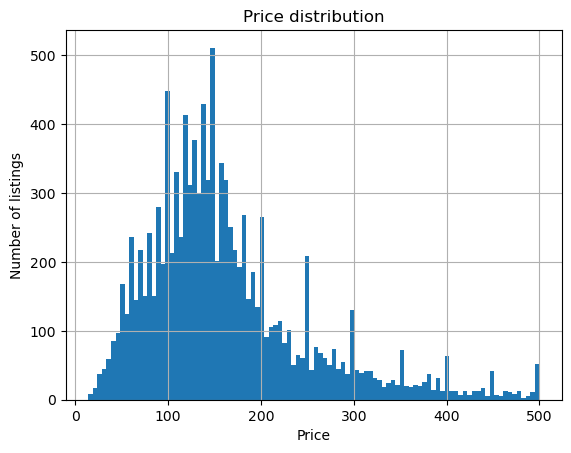

In [708]:
listings['price'].hist(bins = 100)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Number of listings')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=10, decimals = 0))


In [709]:
## drop unreasonable prices
before = listings.shape[0]
listings=listings.loc[listings.accommodates < 7]
after = listings.shape[0]
print(f"Dropped {before - after} rows with accomodates < 7")

Dropped 480 rows with accomodates < 7


In [710]:
listings.groupby(["accommodates"]).agg(mean_price=("price", np.mean))

,mean_price
accommodates,
1,75.221739
2,127.332121
3,147.833333
4,185.221304
5,208.184713
6,240.450902


In [711]:
#How is the average price changing in my district by `property_type`, `room_type` and the `bed_type`?
listings.groupby(["property_type", "room_type"]).agg(mean_price=("price", np.mean))

mean_price
property_type room_type            
House         Entire     214.087363
              Private     83.355140
Rental Unit   Entire     168.344993
              Private     86.223792
              Shared      49.826087

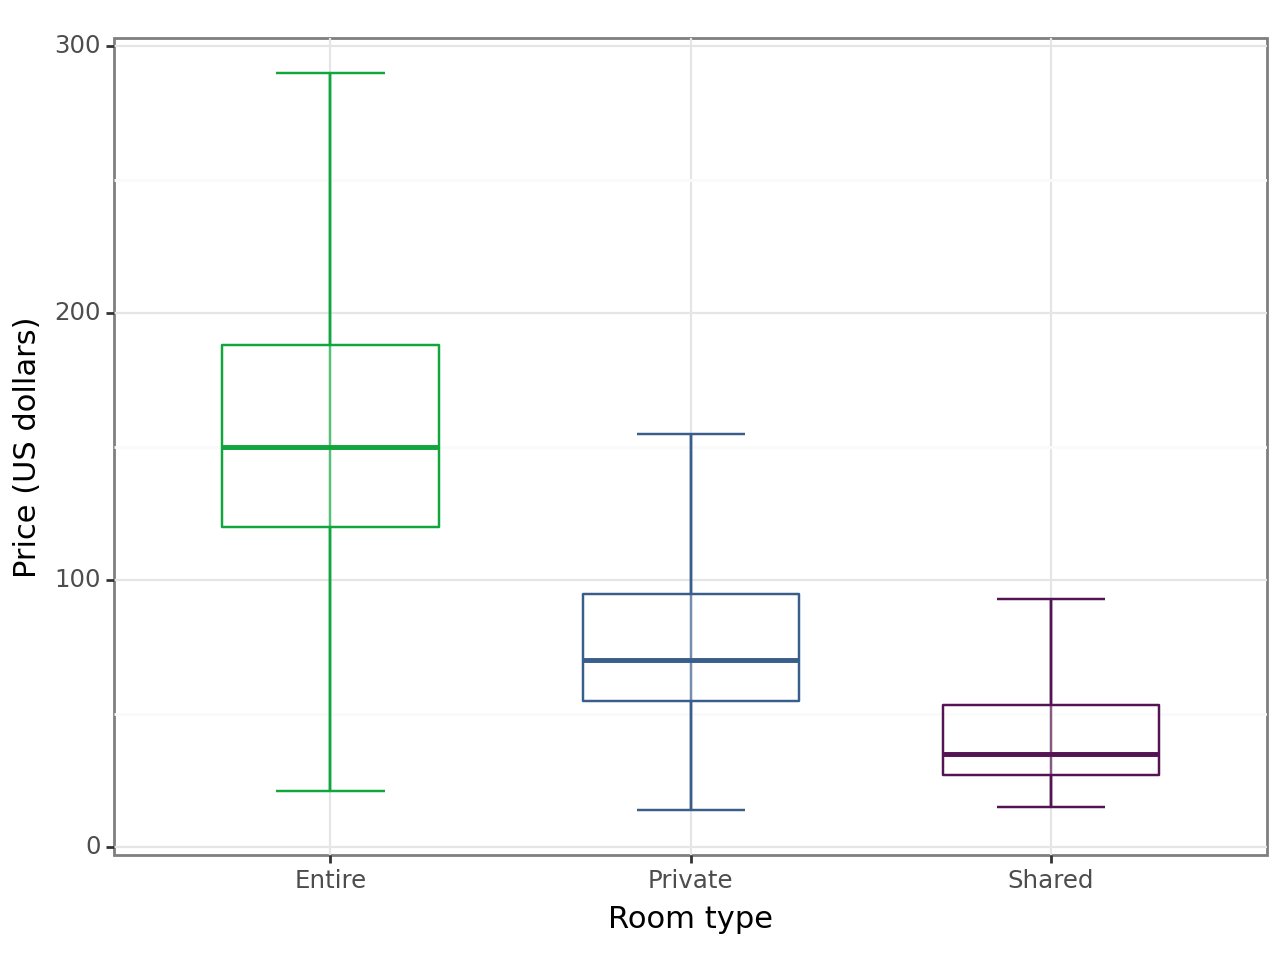

<Figure Size: (640 x 480)>

In [730]:
## Boxplot of price by room type
(
    ggplot(listings, aes(x="room_type", y="price"))
    + stat_boxplot(
        aes(group="room_type"),
        geom="errorbar",
        width=0.3,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="room_type"),
        color=(color[1], color[0], color[2]),
        # fill=(color[1], color[0], color[2]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape="",
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 301, 100))
    + labs(x="Room type", y="Price (US dollars)")
    + theme_bw()
)

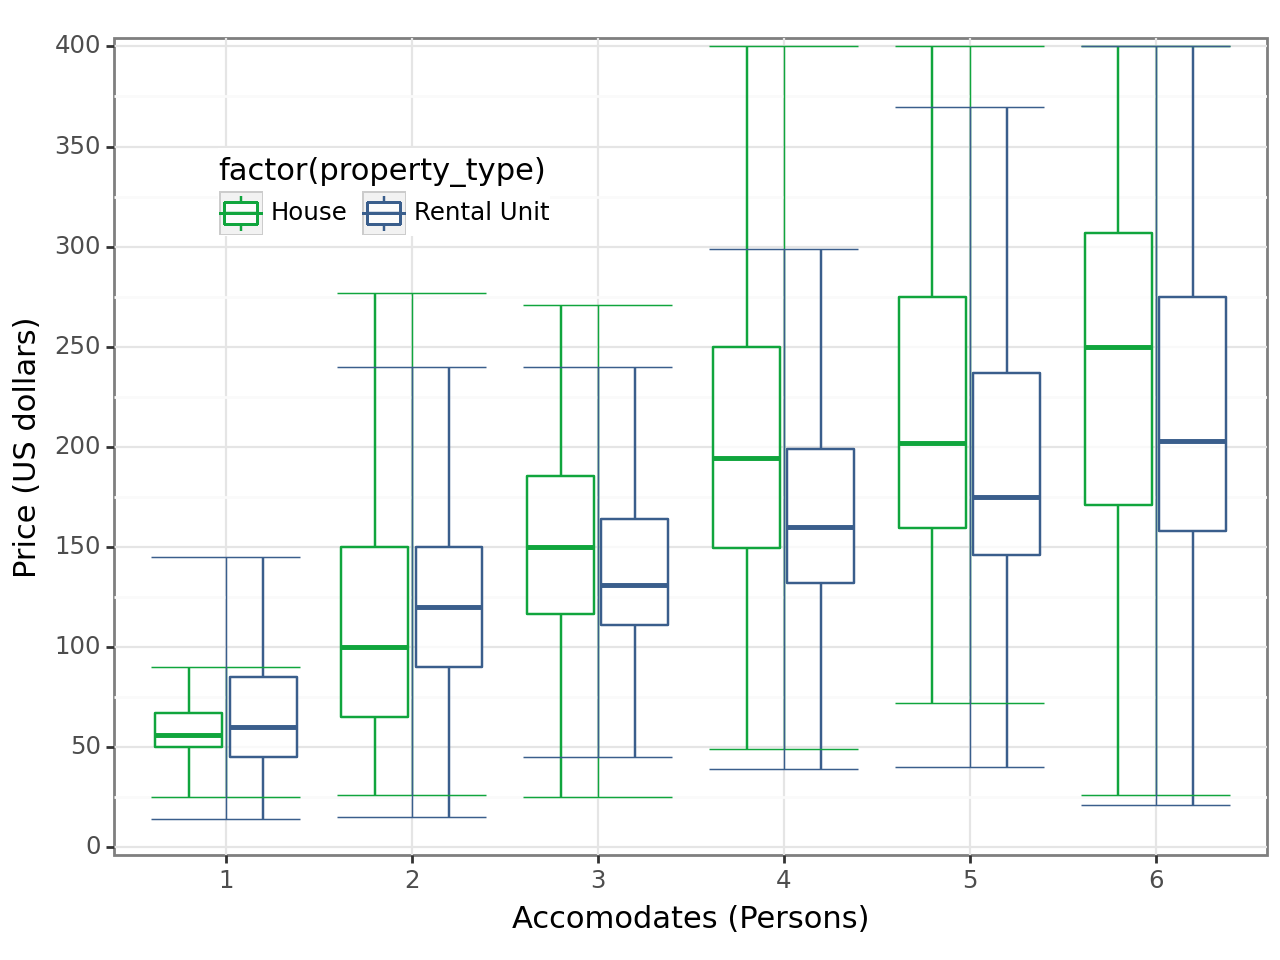

<Figure Size: (640 x 480)>

In [729]:
(
    ggplot(
        listings,
        aes(
            x="factor(accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(property_type)",
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_fill_manual(name="", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)